In [5]:
from math import ceil
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, \
    f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier

In [6]:
def transform_dataset(dataset: pd.DataFrame):
    df = dataset.copy()
    df['CAN ID'] = df['CAN ID'].apply(lambda i: int(i, 16))
    df['Flag'] = df['Flag'].apply(lambda x: 0 if x == 'R' else 1)

    for i in range(8):
        df[f'DATA{i}'] = df[f'DATA{i}'].apply(lambda i: int(i, 16))

    for col in df.columns:
        df[col] = pd.to_numeric(df[col])
    
    return df

In [7]:
# Training data for baseline model and GridSearch
def splitting_data(dataset: pd.DataFrame):
    data_size = len(dataset)
    train_size = ceil(data_size * .6)
    val_size = ceil((data_size - train_size) * .25)
    # print(train_size, test_size)
    train = dataset.iloc[:train_size]
    vali = dataset.iloc[train_size:train_size+val_size]
    test = dataset.iloc[train_size+val_size:]

    X_train = train.drop(columns=['Flag'])
    y_train = train['Flag']

    X_val = vali.drop(columns=['Flag'])
    y_val = vali['Flag']

    X_test = test.drop(columns=['Flag'])
    y_test = test['Flag']

    return X_train, X_val, X_test, y_train, y_val, y_test

In [8]:
# folder_path = '/Users/gabrielchung/Documents/Data 245/Final Presentation/Car Hacking Dataset/9) Car-Hacking Dataset/{0}_dataset.csv'
# folder_path = '/Users/gyanachilakalapudi/Downloads/DATA-228/DATA 245-project/9) Car-Hacking Dataset 2/{0}_dataset.csv'
folder_path = '/Users/MidAutumnFestival/Documents/DATA-270/datasets/Car Hacking Dataset/dataset/{0}_dataset.csv'
column_names = ['Timestamp', 'CAN ID', 'DLC', 'DATA0', 'DATA1', 'DATA2', 'DATA3', 'DATA4', 'DATA5', 'DATA6', 'DATA7', 'Flag']
attacks = {}
for attack in ['DoS', 'Fuzzy', 'gear', 'RPM']:
    data = pd.read_csv(folder_path.format(attack), names=column_names)
    data = data.dropna()
    data_size = ceil(len(data) * 0.5)
    data = data.iloc[:data_size]
    attacks[attack] = data

In [9]:
data.head()

,Timestamp,CAN ID,DLC,DATA0,DATA1,DATA2,DATA3,DATA4,DATA5,DATA6,DATA7,Flag
0,1.478191e+09,0316,8,05,22,68,09,22,20,00,75,R
1,1.478191e+09,018f,8,fe,3b,00,00,00,3c,00,00,R
2,1.478191e+09,0260,8,19,22,22,30,ff,8f,6e,3f,R
3,1.478191e+09,02a0,8,60,00,83,1d,96,02,bd,00,R
4,1.478191e+09,0329,8,dc,b8,7e,14,11,20,00,14,R


In [10]:
for att, data in attacks.items():
    attacks[att] = transform_dataset(data)

In [11]:
model_data = {
    "X_train": [],
    "X_val": [],
    "X_test": [],
    "y_train": [],
    "y_test": [],
    "y_val": [],
}

for att, data in attacks.items():
    x_tr, x_val, x_te, y_tr, y_val, y_te = splitting_data(data)
    model_data["X_train"].append(x_tr)
    model_data["X_val"].append(x_val)
    model_data["X_test"].append(x_te)
    model_data["y_train"].append(y_tr)
    model_data["y_val"].append(y_val)
    model_data["y_test"].append(y_te)

In [12]:
X_train = pd.concat(model_data["X_train"])
y_train = pd.concat(model_data["y_train"]).values

# For feature selection validation
X_train_pca = X_train.drop(columns=['DLC', 'DATA0', 'DATA1', 'DATA2', 'DATA6'])
X_train_tsvd = X_train.drop(columns=['DLC', 'DATA1', 'DATA2', 'DATA4', 'DATA6'])
X_test_pca = pd.concat(model_data["X_test"]).drop(columns=['DLC', 'DATA0', 'DATA1', 'DATA2', 'DATA6'])
X_test_tsvd = pd.concat(model_data["X_test"]).drop(columns=['DLC', 'DATA1', 'DATA2', 'DATA4', 'DATA6'])
y_test_fe = pd.concat(model_data["y_test"])

X_train = X_train.values
X_train_pca = X_train_pca.values
X_train_tsvd = X_train_tsvd.values
X_test_pca = X_test_pca.values
X_test_tsvd = X_test_tsvd.values
y_test_fe = y_test_fe.values

## Baseline model to compare the Features selected by the methods

In [13]:
from sklearn.ensemble import RandomForestClassifier


rf_pca = RandomForestClassifier()
rf_tsvd = RandomForestClassifier()

for fe_type, xtr, xte, model in [('PCA', X_train_pca, X_test_pca, rf_pca), ('TVSD', X_train_pca, X_test_pca, rf_pca)]:
    start_time = datetime.now()
    model.fit(xtr, y_train)
    end_time = datetime.now()
    time_diff = end_time - start_time
    print(f"Training time: {time_diff.total_seconds() / 60}")

    y_pred = model.predict(xte)
    print(
        f"""
        {fe_type}
        Accuracy: {accuracy_score(y_test_fe, y_pred)}
        Precision: {precision_score(y_test_fe, y_pred)}
        Recall: {recall_score(y_test_fe, y_pred)}
        F1-Score: {f1_score(y_test_fe, y_pred)}
        ROC AUC: {roc_auc_score(y_test_fe, y_pred)}
        """
    )

Training time: 5.375629316666666

        PCA
        Accuracy: 0.9999983708837833
        Precision: 0.9999977951617028
        Recall: 0.9999933855142763
        F1-Score: 0.9999955903331283
        ROC AUC: 0.9999964429780678
        
Training time: 3.9180901

        PCA
        Accuracy: 0.9999979636047291
        Precision: 0.9999977951568415
        Recall: 0.9999911806857017
        F1-Score: 0.9999944879103337
        ROC AUC: 0.9999953405637804
        


In [15]:
import numpy as np

rf_baseline = rf_pca

X_train = X_train_tsvd
model_data["X_val"] = [ x_val.drop(columns=['DLC', 'DATA0', 'DATA1', 'DATA6', 'DATA2']) for x_val in model_data["X_val"]]
model_data["X_test"] = [ x_test.drop(columns=['DLC', 'DATA0', 'DATA1', 'DATA6', 'DATA2']) for x_test in model_data["X_test"]]
X_val = pd.concat(model_data["X_val"]).values
X_test = pd.concat(model_data["X_test"]).values
model_data["X_val"] = [ x_val.values for x_val in model_data["X_val"]]
model_data["X_test"] = [ x_test.values for x_test in model_data["X_test"]]

y_val = pd.concat(model_data["y_val"]).values
y_test = pd.concat(model_data["y_test"]).values
model_data["y_val"] = [y_val.values for y_val in model_data["y_val"]]
model_data["y_test"] = [y_test.values for y_test in model_data["y_test"]]

In [16]:
# To keep track of the validation training loss using mean squaread error
train_mses = []
val_mses = {
    'DoS': [],
    'Fuzzy': [],
    'gear': [],
    'RPM': [],
}


    Overall performance
    Accuracy: 0.9999979636047291
    Precision: 0.9999977951568415
    Recall: 0.9999911806857017
    F1-Score: 0.9999944879103337
    ROC AUC: 0.9999953405637804

    


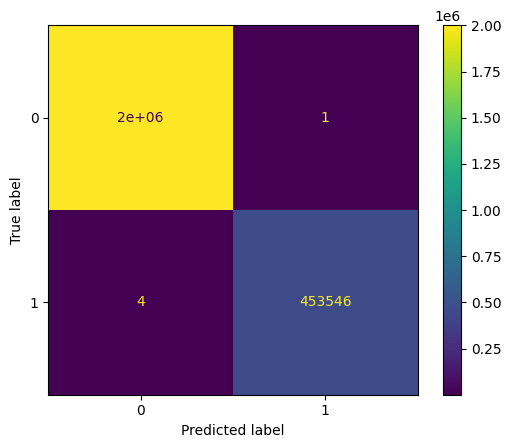

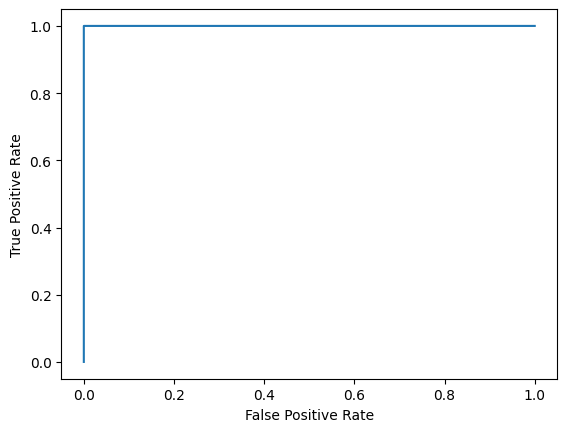

In [17]:
y_train_pred = rf_baseline.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_mses.append(train_mse)

y_pred_base = rf_baseline.predict(X_test)
print(
    f"""
    Overall performance
    Accuracy: {accuracy_score(y_test, y_pred_base)}
    Precision: {precision_score(y_test, y_pred_base)}
    Recall: {recall_score(y_test, y_pred_base)}
    F1-Score: {f1_score(y_test, y_pred_base)}
    ROC AUC: {roc_auc_score(y_test, y_pred_base)}\n
    """
)
conf_matrix = confusion_matrix(y_test, y_pred_base)
cm_display = ConfusionMatrixDisplay(conf_matrix).plot()
fpr, tpr, _ = roc_curve(y_test, y_pred_base)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()



        DoS
        Accuracy: 1.0
        Precision: 1.0
        Recall: 1.0
        F1-Score: 1.0
        ROC AUC: 1.0

        

        Fuzzy
        Accuracy: 0.9999911135282314
        Precision: 0.9999886177381169
        Recall: 0.9999544725070852
        F1-Score: 0.9999715448311186
        ROC AUC: 0.9999761831652559

        

        gear
        Accuracy: 1.0
        Precision: 1.0
        Recall: 1.0
        F1-Score: 1.0
        ROC AUC: 1.0

        

        RPM
        Accuracy: 1.0
        Precision: 1.0
        Recall: 1.0
        F1-Score: 1.0
        ROC AUC: 1.0

        


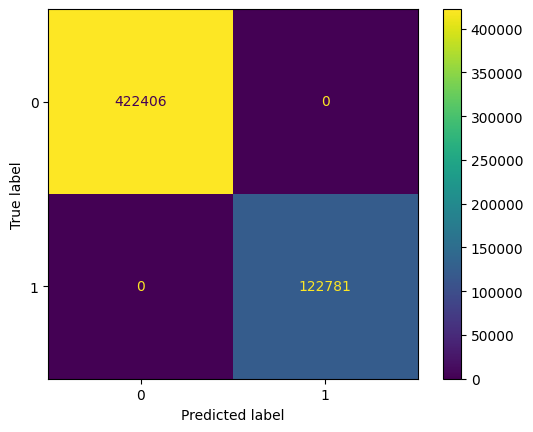

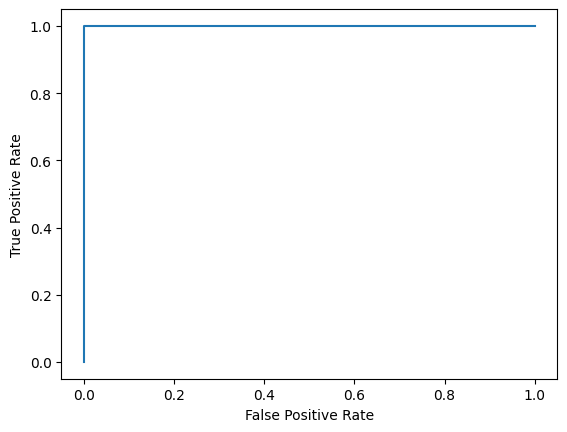

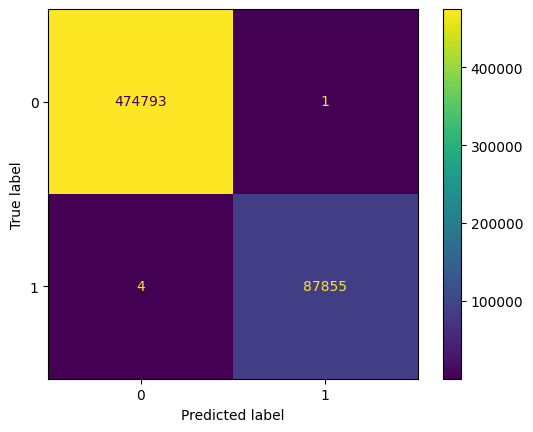

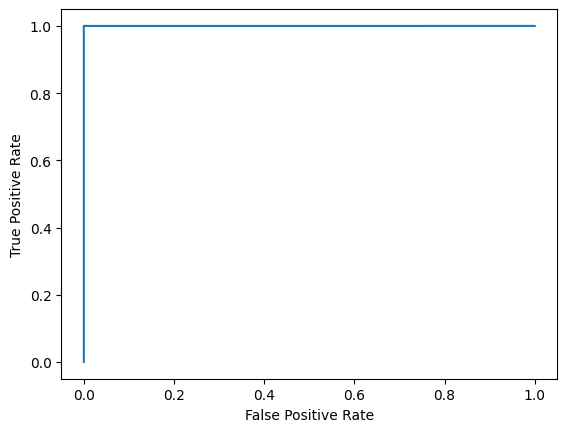

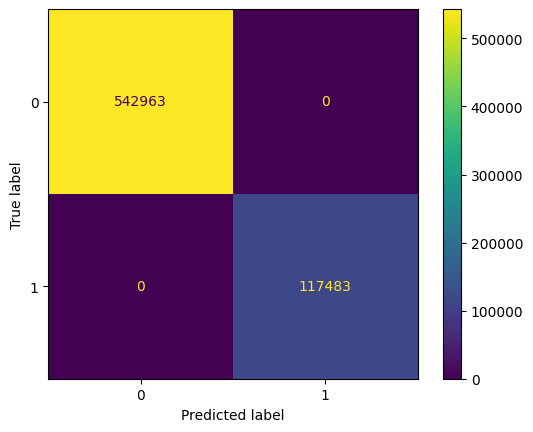

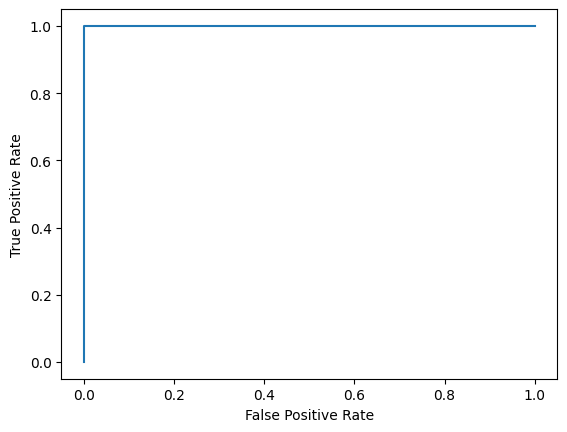

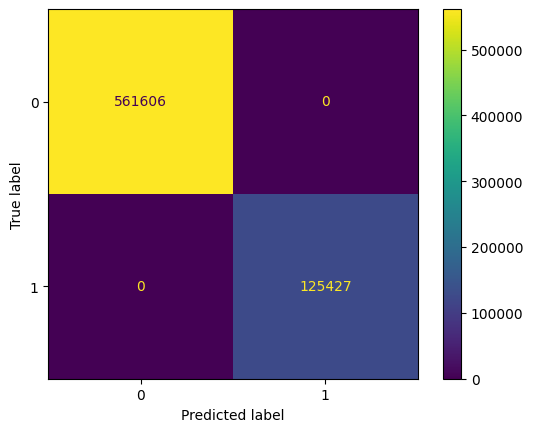

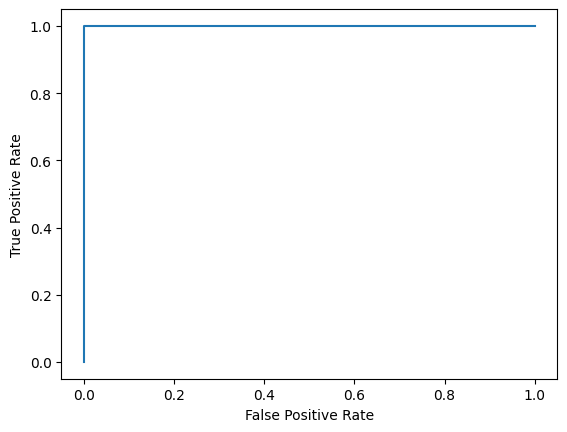

In [18]:
for i, att in enumerate(['DoS', 'Fuzzy', 'gear', 'RPM']):
    y_val_pred = rf_baseline.predict(model_data["X_val"][i])
    val_mse = mean_squared_error(model_data["y_val"][i], y_val_pred)
    val_mses[att].append(val_mse)


    y_pred_att = rf_baseline.predict(model_data["X_test"][i])

    print(
        f"""
        {att}
        Accuracy: {accuracy_score(model_data["y_test"][i], y_pred_att)}
        Precision: {precision_score(model_data["y_test"][i], y_pred_att)}
        Recall: {recall_score(model_data["y_test"][i], y_pred_att)}
        F1-Score: {f1_score(model_data["y_test"][i], y_pred_att)}
        ROC AUC: {roc_auc_score(model_data["y_test"][i], y_pred_att)}\n
        """
    )
    conf_matrix = confusion_matrix(model_data["y_test"][i], y_pred_att)
    cm_display = ConfusionMatrixDisplay(conf_matrix).plot()
    fpr, tpr, _ = roc_curve(model_data["y_test"][i], y_pred_att)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [19]:
rf_5_fold = RandomForestClassifier()
start_time = datetime.now()
rf_5_fold = GridSearchCV(rf_5_fold, param_grid={}, cv=5, scoring='accuracy')
rf_5_fold.fit(X_train, y_train)
end_time = datetime.now()
time_diff = end_time - start_time
print(f"Training time: {time_diff.total_seconds() / 60}")

Training time: 23.36758725



    Accuracy: 0.7179722879185964
    Precision: 0.36887766862411503
    Recall: 0.7409679197442399
    F1-Score: 0.49254873222922474
    ROC AUC: 0.7268649908502198

    


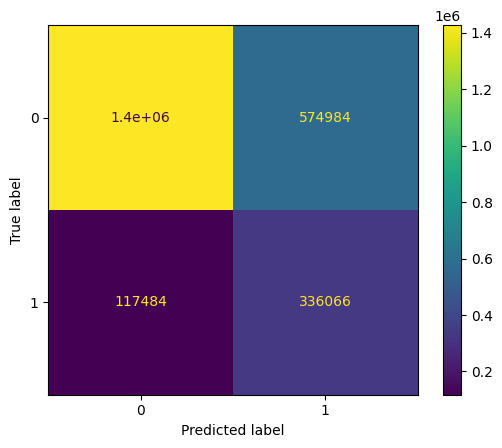

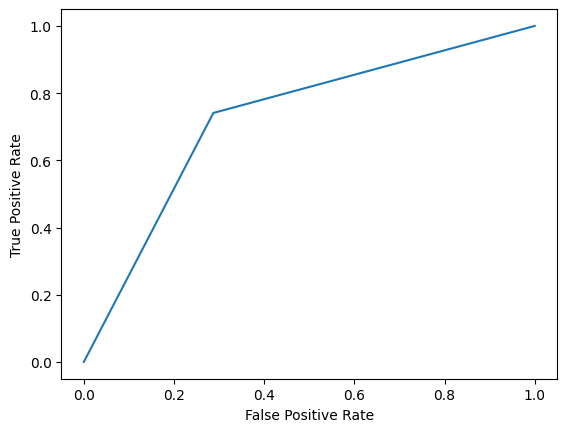

In [20]:
y_pred_k_fold = rf_5_fold.predict(X_test)
print(
    f"""
    Accuracy: {accuracy_score(y_test, y_pred_k_fold)}
    Precision: {precision_score(y_test, y_pred_k_fold)}
    Recall: {recall_score(y_test, y_pred_k_fold)}
    F1-Score: {f1_score(y_test, y_pred_k_fold)}
    ROC AUC: {roc_auc_score(y_test, y_pred_k_fold)}\n
    """
)
conf_matrix = confusion_matrix(y_test, y_pred_k_fold)
cm_display = ConfusionMatrixDisplay(conf_matrix).plot()
fpr, tpr, _ = roc_curve(y_test, y_pred_k_fold)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()


        DoS
        Accuracy: 0.6713219500831825
        Precision: 0.40659730041195874
        Recall: 1.0
        F1-Score: 0.5781289361111046
        ROC AUC: 0.7878924541791547

        

        Fuzzy
        Accuracy: 0.5511994070946036
        Precision: 0.2581204315227866
        Recall: 0.9999886181267713
        F1-Score: 0.4103261059932046
        ROC AUC: 0.7340705610800498

        

        gear
        Accuracy: 0.6603507326866996
        Precision: 0.0
        Recall: 0.0
        F1-Score: 0.0
        ROC AUC: 0.40161668474647444

        

        RPM
        Accuracy: 0.946963246306946
        Precision: 0.7748864794736354
        Recall: 1.0
        F1-Score: 0.8731673697840524
        ROC AUC: 0.9675591072744949

        


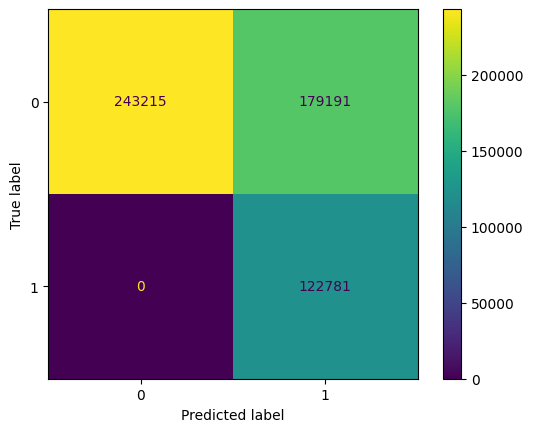

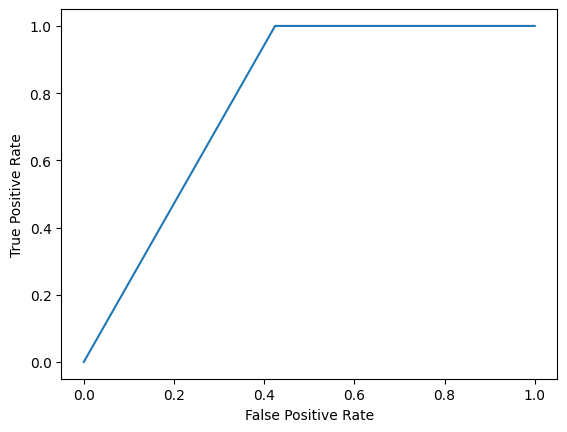

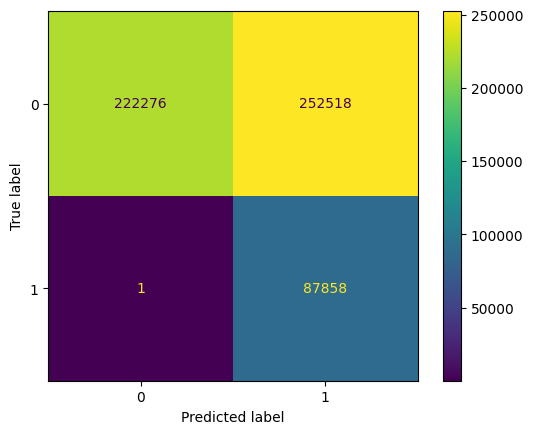

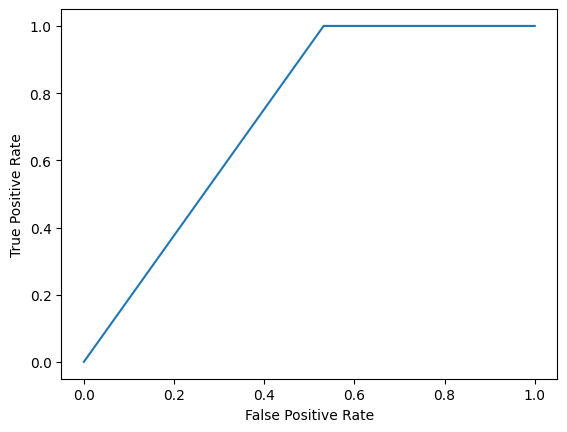

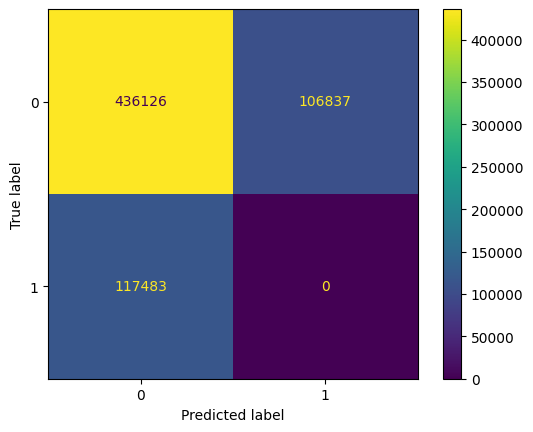

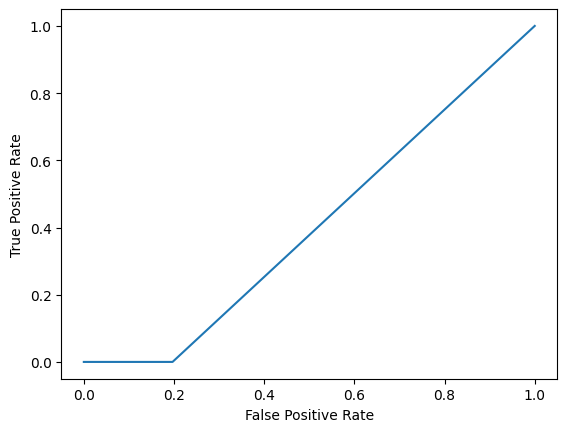

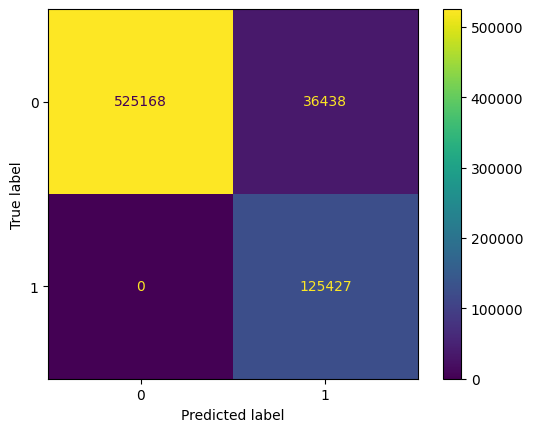

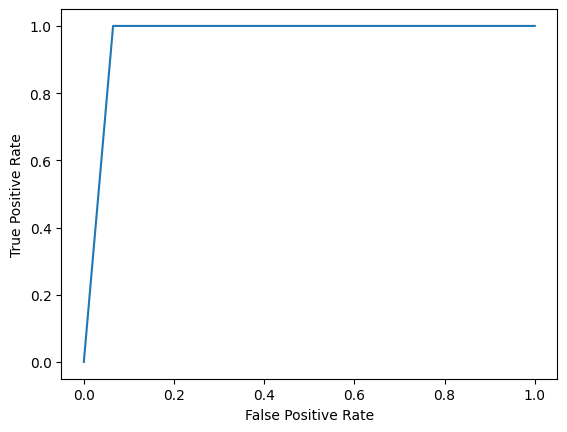

In [22]:
for i, att in enumerate(['DoS', 'Fuzzy', 'gear', 'RPM']):
    y_pred_att = rf_5_fold.predict(model_data["X_test"][i])
    print(
        f"""
        {att}
        Accuracy: {accuracy_score(model_data["y_test"][i], y_pred_att)}
        Precision: {precision_score(model_data["y_test"][i], y_pred_att)}
        Recall: {recall_score(model_data["y_test"][i], y_pred_att)}
        F1-Score: {f1_score(model_data["y_test"][i], y_pred_att)}
        ROC AUC: {roc_auc_score(model_data["y_test"][i], y_pred_att)}\n
        """
    )
    conf_matrix = confusion_matrix(model_data["y_test"][i], y_pred_att)
    cm_display = ConfusionMatrixDisplay(conf_matrix).plot()
    fpr, tpr, _ = roc_curve(model_data["y_test"][i], y_pred_att)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

## Grid search

In [23]:
params_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6]
}

rf_grid_search = RandomForestClassifier()
start_time = datetime.now()
grid_search = GridSearchCV(rf_grid_search, params_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
end_time = datetime.now()
time_diff = end_time - start_time
print(f"Training time: {time_diff.total_seconds() / 60}")

Training time: 122.71658416666668


Grid Search
Best Hyperparameters: {'max_depth': 7, 'min_samples_split': 6}
Best Accuracy: 0.9978414240899107

    Accuracy: 0.9137786169536423
    Precision: 0.7876955945574929
    Recall: 0.7299856686142653
    F1-Score: 0.7577434197953703
    ROC AUC: 0.8427035491798278

    


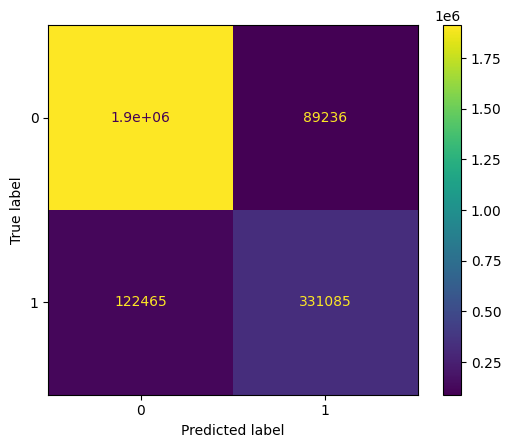

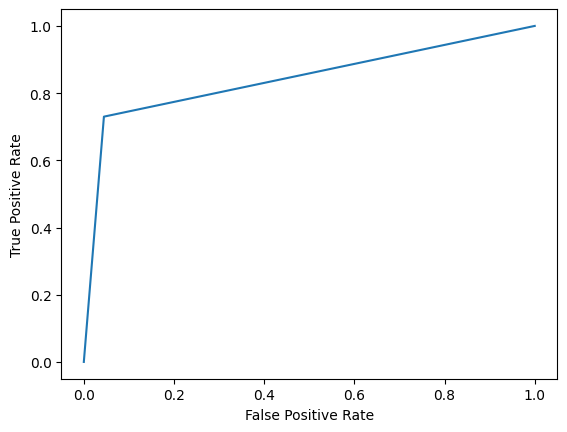

In [24]:
print('Grid Search')
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)
y_pred_gs = grid_search.predict(X_test)
print(
    f"""
    Accuracy: {accuracy_score(y_test, y_pred_gs)}
    Precision: {precision_score(y_test, y_pred_gs)}
    Recall: {recall_score(y_test, y_pred_gs)}
    F1-Score: {f1_score(y_test, y_pred_gs)}
    ROC AUC: {roc_auc_score(y_test, y_pred_gs)}\n
    """
)
conf_matrix = confusion_matrix(y_test, y_pred_gs)
cm_display = ConfusionMatrixDisplay(conf_matrix).plot()
fpr, tpr, _ = roc_curve(y_test, y_pred_gs)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()


        DoS
        Accuracy: 0.9433423761021448
        Precision: 0.7989913450901281
        Recall: 1.0
        F1-Score: 0.8882659133083259
        ROC AUC: 0.9634368356510087

        

        Fuzzy
        Accuracy: 0.9017902686024957
        Precision: 0.6224193221331852
        Recall: 0.9432955075746366
        F1-Score: 0.7499773767940203
        ROC AUC: 0.9187026870847061

        

        gear
        Accuracy: 0.8138258086202355
        Precision: 0.0
        Recall: 0.0
        F1-Score: 0.0
        ROC AUC: 0.49495821998920736

        

        RPM
        Accuracy: 0.996221433322708
        Precision: 0.9797223936323942
        Recall: 1.0
        F1-Score: 0.9897573485894654
        ROC AUC: 0.9976887711313626

        


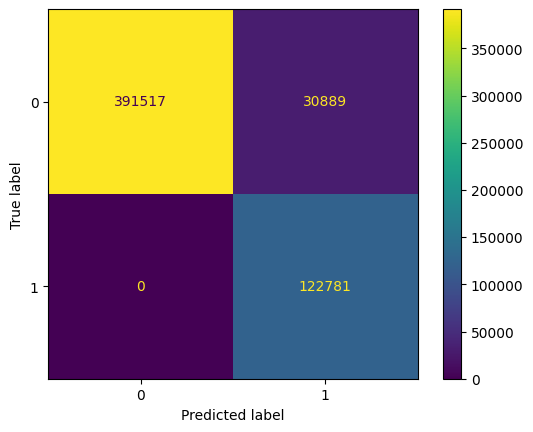

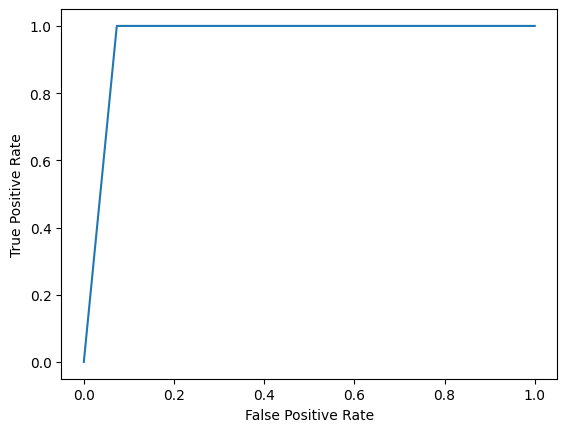

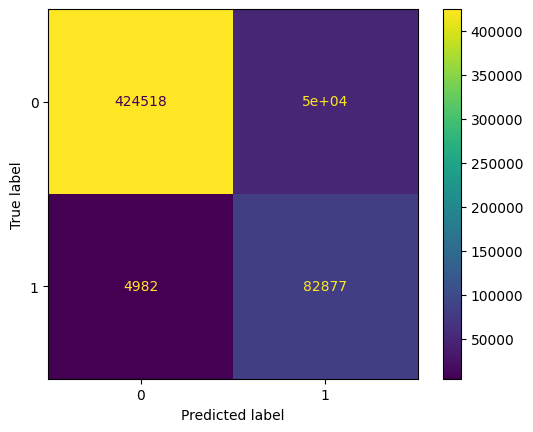

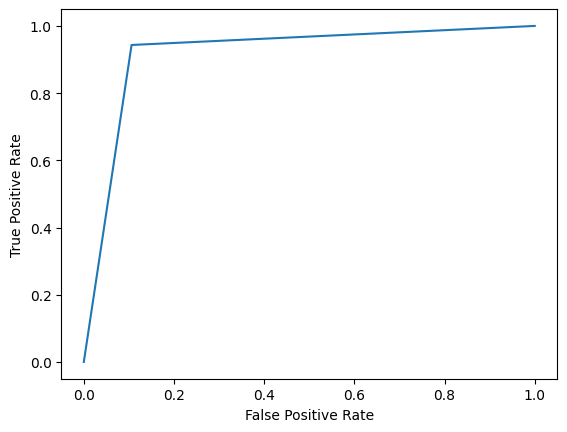

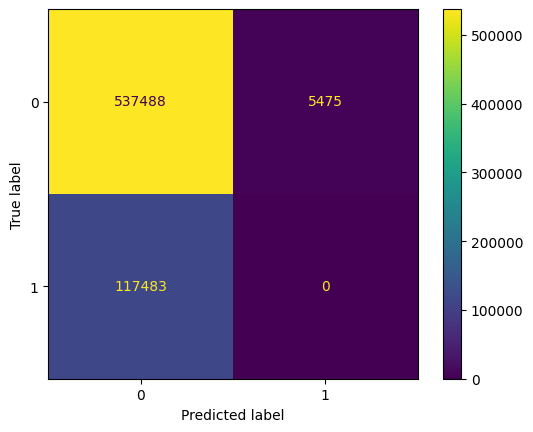

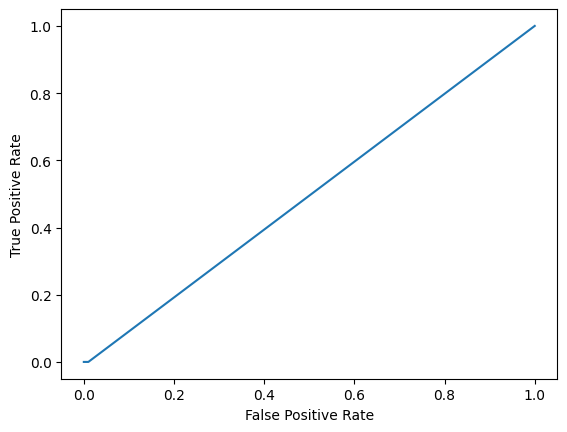

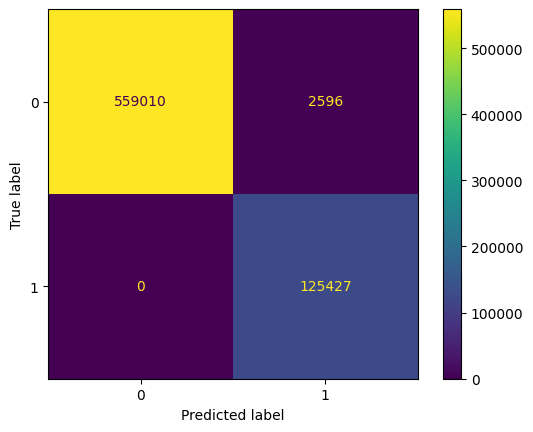

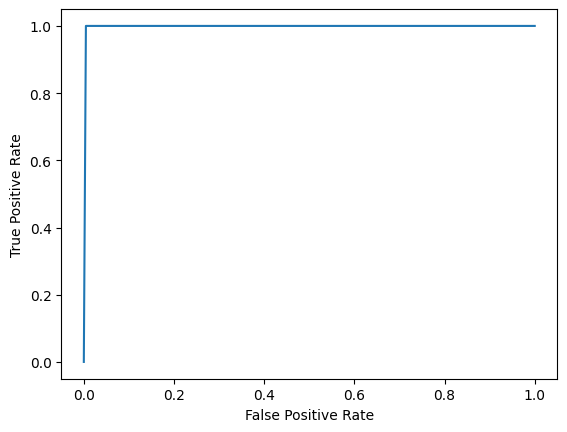

In [26]:
# Prediction for each attack
for i, att in enumerate(['DoS', 'Fuzzy', 'gear', 'RPM']):
    y_pred_att = grid_search.predict(model_data["X_test"][i])

    print(
        f"""
        {att}
        Accuracy: {accuracy_score(model_data["y_test"][i], y_pred_att)}
        Precision: {precision_score(model_data["y_test"][i], y_pred_att)}
        Recall: {recall_score(model_data["y_test"][i], y_pred_att)}
        F1-Score: {f1_score(model_data["y_test"][i], y_pred_att)}
        ROC AUC: {roc_auc_score(model_data["y_test"][i], y_pred_att)}\n
        """
    )
    conf_matrix = confusion_matrix(model_data["y_test"][i], y_pred_att)
    cm_display = ConfusionMatrixDisplay(conf_matrix).plot()
    fpr, tpr, _ = roc_curve(model_data["y_test"][i], y_pred_att)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

## Custom Grid search

In [27]:
max_depths = [3, 5, 7, 9]
min_samples_split = [2, 4, 6]
min_samples_leaf = [1, 2, 3]
temp_grid = [{ "max_depth": md, "min_samples_split": mss } for mss in min_samples_split for md in max_depths]
params_grid = []
for msl in min_samples_leaf:
    for tg in temp_grid:
        pg = tg.copy()
        pg["min_samples_leaf"] = msl
        params_grid.append(pg)

for param_grid in params_grid:
    dtc = RandomForestClassifier(**param_grid)
    # start_time = datetime.now()
    dtc.fit(X_train, y_train)
    # end_time = datetime.now()
    # time_diff = end_time - start_time
    # print(f"Training time: {time_diff.total_seconds() / 60}")

    y_train_pred = dtc.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_mses.append(train_mse)
    
    for i, att in enumerate(['DoS', 'Fuzzy', 'gear', 'RPM']):
        # evaluate the accuracy on the validation set
        y_val_pred = dtc.predict(model_data["X_val"][i])
        val_mse = mean_squared_error(model_data["y_val"][i], y_val_pred)
        val_mses[att].append(val_mse)

        y_pred_att = dtc.predict(model_data["X_test"][i])

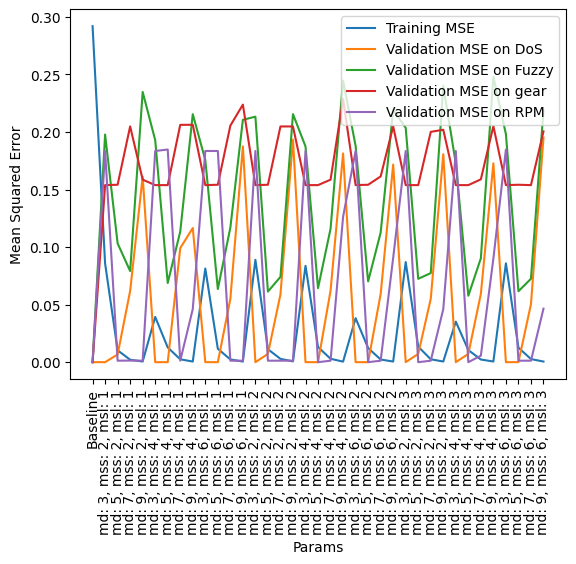

In [28]:
params = ["Baseline"]
temp = [f"md: {p['max_depth']}, mss: {p['min_samples_split']}, msl: {p['min_samples_leaf']}" for p in params_grid]
params.extend(temp)
# print(params)
plt.plot(params, train_mses, label='Training MSE')
for att in ['DoS', 'Fuzzy', 'gear', 'RPM']:
    plt.plot(params, val_mses[att], label=f'Validation MSE on {att}')
plt.xlabel('Params')
plt.ylabel('Mean Squared Error')
plt.xticks(rotation=90)
plt.legend()
plt.show()